<a href="https://colab.research.google.com/github/adityawithdoublea/qstp_dl/blob/master/qstp_dl_cv_transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning for Image Classification in PyTorch**
Dataset used: STL-10


Importing the required modules and classes

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as tt
from torchvision.datasets import STL10
from torchvision import utils
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import datasets
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Downloading and visualizing the dataset

In [2]:
dataset = STL10(root='./data', download=True, transform=tt.ToTensor())
test_dataset = STL10(root='./data', split ='test', transform=tt.ToTensor())
dataset_size = len(dataset)
train_ds = dataset

test_dataset_size = len(test_dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

print(dataset_size,train_ds.data.shape,test_dataset_size)
print(classes, num_classes)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
5000 (5000, 3, 96, 96) 8000
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] 10


In [3]:
batch_size = 256

train_dl_for_mean_std = DataLoader(dataset, batch_size, shuffle=True)

def get_mean_std(loader):
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  for data, _ in loader:
    channels_sum += torch.mean(data, dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
    num_batches += 1
    mean = channels_sum / num_batches 
    std = (channels_squared_sum / num_batches  - (mean **2))**.5
  return mean, std

stats=get_mean_std(train_dl_for_mean_std)
stats

(tensor([0.4466, 0.4397, 0.4066]), tensor([0.2603, 0.2566, 0.2712]))

In [4]:
meanRGB=[np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
stdRGB=[np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

meanR=np.mean([m[0] for m in meanRGB])
meanG=np.mean([m[1] for m in meanRGB])
meanB=np.mean([m[2] for m in meanRGB])

stdR=np.mean([s[0] for s in stdRGB])
stdG=np.mean([s[1] for s in stdRGB])
stdB=np.mean([s[2] for s in stdRGB])

print(meanR,meanG,meanB)
print(stdR,stdG,stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


In [5]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    

Label:  bird (1)


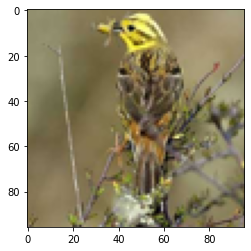

In [6]:
show_example(*dataset[0])

Label:  bird (1)


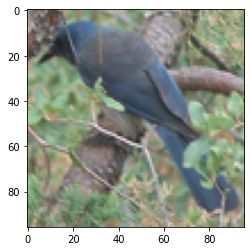

In [7]:
show_example(*dataset[256])

In [8]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 96, 96]) 1


tensor([[[0.5725, 0.5725, 0.5725,  ..., 0.6353, 0.6353, 0.6353],
         [0.5725, 0.5725, 0.5725,  ..., 0.6392, 0.6392, 0.6392],
         [0.5725, 0.5725, 0.5725,  ..., 0.6431, 0.6431, 0.6431],
         ...,
         [0.5098, 0.5176, 0.4588,  ..., 0.5373, 0.5882, 0.5529],
         [0.5255, 0.6078, 0.3451,  ..., 0.5294, 0.5333, 0.5373],
         [0.5294, 0.3804, 0.4549,  ..., 0.5412, 0.5765, 0.5412]],

        [[0.5608, 0.5608, 0.5608,  ..., 0.6235, 0.6235, 0.6235],
         [0.5608, 0.5608, 0.5608,  ..., 0.6196, 0.6196, 0.6196],
         [0.5608, 0.5608, 0.5608,  ..., 0.6196, 0.6196, 0.6196],
         ...,
         [0.4471, 0.4667, 0.4078,  ..., 0.5176, 0.5412, 0.4784],
         [0.4627, 0.5529, 0.2902,  ..., 0.5137, 0.4863, 0.4706],
         [0.4667, 0.3255, 0.4078,  ..., 0.4980, 0.5333, 0.5020]],

        [[0.4314, 0.4314, 0.4314,  ..., 0.4941, 0.4941, 0.4941],
         [0.4314, 0.4314, 0.4314,  ..., 0.4941, 0.4941, 0.4941],
         [0.4314, 0.4314, 0.4314,  ..., 0.4941, 0.4941, 0.

## Creating validation and training dataset

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2,
random_state=0)
indices=list(range(len(test_dataset)))
y_test0=[y for _,y in test_dataset]

for test_index, val_index in sss.split(indices, y_test0):
    print("test:", test_index, "val:", val_index)
    print(len(val_index),len(test_index))

valid_ds=Subset(test_dataset,val_index)
test_ds=Subset(test_dataset,test_index)
y_test=[y for _,y in test_ds]
y_val=[y for _,y in valid_ds]

counter_test=collections.Counter(y_test)
counter_val=collections.Counter(y_val)

print(counter_test)
print(counter_val)

test: [2096 4321 2767 ... 3206 3910 2902] val: [6332 6852 1532 ... 5766 4469 1011]
1600 6400
Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


## Visualizing dataset like we did in previous notebook

image indices: [4041 2667 1626  439]
torch.Size([3, 100, 394])


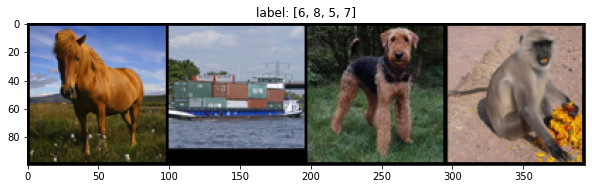

In [10]:
np.random.seed(69)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(test_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[test_ds[i][0] for i in rnd_inds]
y_grid=[test_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [1078 1227  619  439]
torch.Size([3, 100, 394])


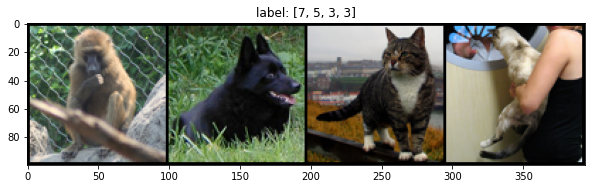

In [11]:
np.random.seed(69)

grid_size=4
rnd_inds=np.random.randint(0,len(valid_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[valid_ds[i][0] for i in rnd_inds]
y_grid=[valid_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [12]:
#data transformation
img_size = 256
train_tfms =  tt.Compose([
        tt.Resize((272,272)),
        tt.RandomRotation(5,),
        tt.RandomCrop(224),
        tt.RandomHorizontalFlip(p=0.5),
        tt.RandomVerticalFlip(p=0.5),
        tt.ToTensor(),
        tt.Normalize(*stats)])

valid_tfms = tt.Compose([
        tt.Resize(256),      
        tt.ToTensor(),
        tt.Normalize(*stats)])  
            

In [13]:
train_ds.transform =  train_tfms
valid_ds.transform =  valid_tfms

In [14]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: bird (1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


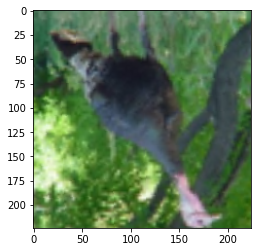

In [15]:
show_image(*dataset[2])

In [16]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

In [18]:
len(dataset.classes)

10

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

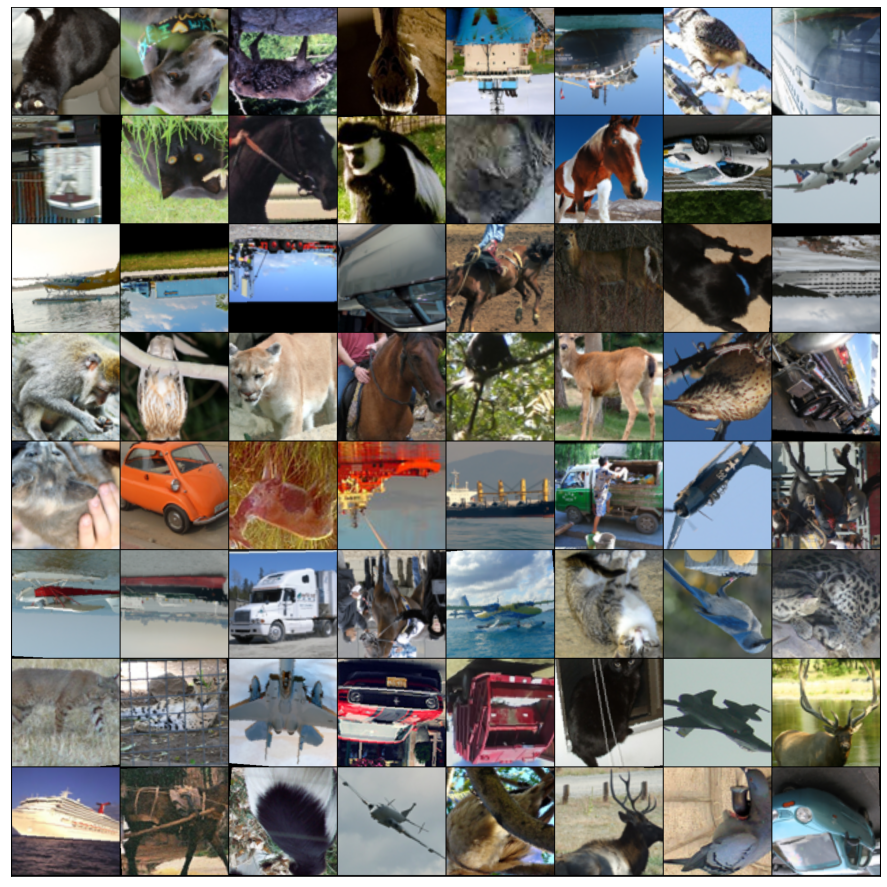

In [19]:
show_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

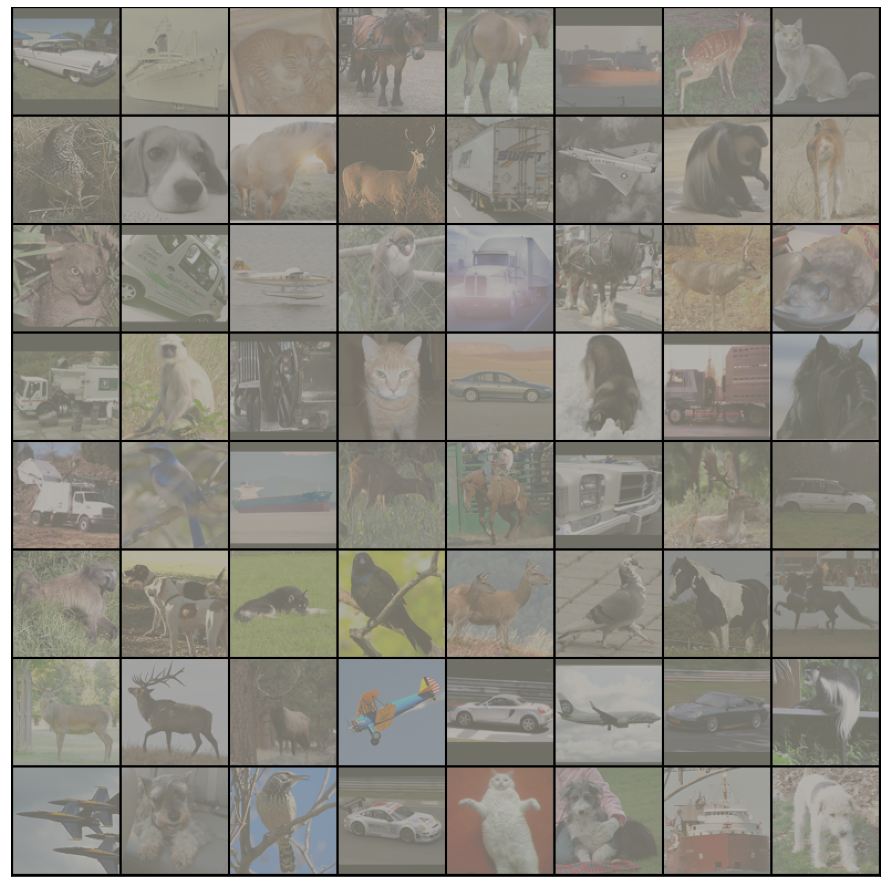

In [20]:
show_batch(valid_dl)

## Creating the base class

In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  #generate predictions
        loss = F.cross_entropy(out, labels)  #calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    #generate predictions
        loss = F.cross_entropy(out, labels)   #calculate loss
        acc = accuracy(out, labels)           #calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   #combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      #combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.7f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

## We are using ResNet34 as are pre-trained model

In [22]:
class Stl10Model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        #use a pretrained model
        self.network = models.resnet34(pretrained=True)
        #replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## Rest of the procedure is pretty much the same

In [23]:
#choosing gpu if available
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

#moving data and model to gpu
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

#constructing helper class dataloader
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):

        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

In [24]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    #setting up a custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    #setting up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        #training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            #gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            #record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        #validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Let's analyze the model!

In [27]:
model = Stl10Model(len(dataset.classes))
to_device(model, device);
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Stl10Model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [28]:
torch.cuda.empty_cache()
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[{'val_acc': 0.12079326808452606, 'val_loss': 2.711376905441284}]

In [29]:
torch.cuda.empty_cache()
epochs = 8
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-6
opt_func = torch.optim.Adam

In [30]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.0000391, train_loss: 1.7325, val_loss: 1.7939, val_acc: 0.3546


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.0000935, train_loss: 0.4371, val_loss: 1.7991, val_acc: 0.3984


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.0000972, train_loss: 0.2865, val_loss: 1.7270, val_acc: 0.4681


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.0000812, train_loss: 0.2007, val_loss: 2.1273, val_acc: 0.4075


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.0000556, train_loss: 0.1324, val_loss: 2.2904, val_acc: 0.4183


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.0000283, train_loss: 0.0940, val_loss: 2.0793, val_acc: 0.4044


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.0000077, train_loss: 0.0685, val_loss: 2.0241, val_acc: 0.4111


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.0000000, train_loss: 0.0633, val_loss: 2.1003, val_acc: 0.4171
CPU times: user 3min 34s, sys: 2min 38s, total: 6min 12s
Wall time: 7min 4s


### **NOTE**: 
So, I managed to get an accuracy of over 70% while tuning. I thought maybe I could get to 80% with proper configuration but I messed up and forgot what was the configuration that allowed the model to reach 70% in the frist place. I've spent more than half a day to figure out what went wrong but failed.

Some answers on stackoverflow suggested that the model either too complex (which probably isn't the case here), or either the dataset is too small. 

In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs No. of epochs');

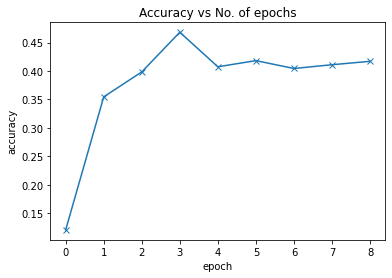

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No. of epochs');

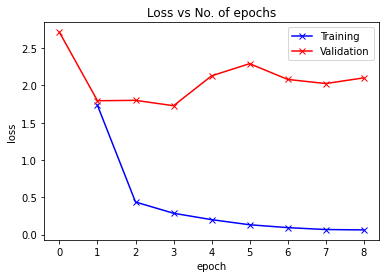

In [34]:
plot_losses(history)

In [35]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

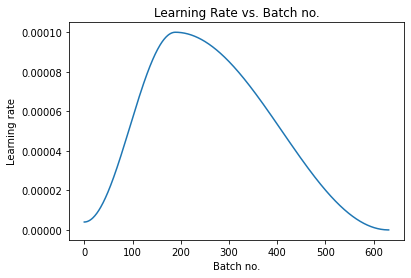

In [36]:
plot_lrs(history)

## Let's try how the model performs after freezing the weights

In [37]:
model2 = Stl10Model(len(dataset.classes), pretrained=False)
to_device(model2, device);

In [38]:
history2 = [evaluate(model2, valid_dl)]
history2

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.05709134787321091, 'val_loss': 3.156038761138916}]

In [40]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=0, 
                         opt_func=opt_func)

  0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.0000391, train_loss: 0.0668, val_loss: 2.3453, val_acc: 0.3804


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.0000935, train_loss: 0.0802, val_loss: 3.2839, val_acc: 0.3167


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.0000972, train_loss: 0.1550, val_loss: 2.4734, val_acc: 0.3654


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.0000812, train_loss: 0.1352, val_loss: 2.5469, val_acc: 0.3498


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.0000556, train_loss: 0.0848, val_loss: 2.9184, val_acc: 0.3167


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.0000283, train_loss: 0.0523, val_loss: 3.1304, val_acc: 0.3263


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.0000077, train_loss: 0.0322, val_loss: 3.0685, val_acc: 0.3534


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.0000000, train_loss: 0.0324, val_loss: 3.1017, val_acc: 0.3546
CPU times: user 3min 39s, sys: 2min 42s, total: 6min 21s
Wall time: 7min 4s


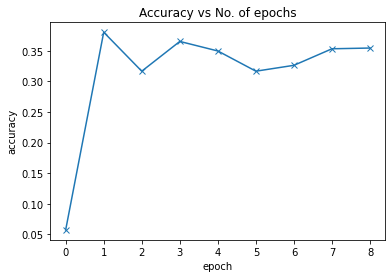

In [41]:
plot_accuracies(history2)

### Apparently both the model have almost same accuracy which wasn't supposed to happen. Something is wrong. But to be fair, the validation loss of the second model with fixed weights is higher than the first model, which is a good thing. 

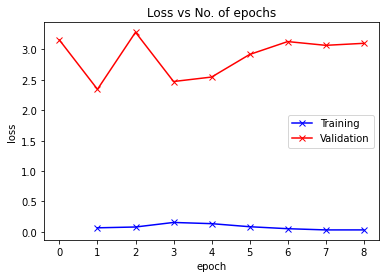

In [42]:
plot_losses(history2)

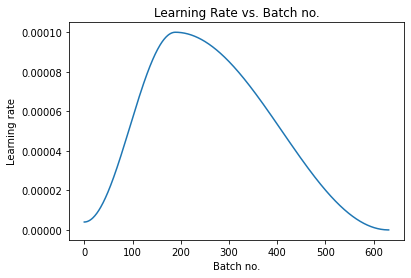

In [43]:
plot_lrs(history2)